Note: this notebook is supposed to be only for training logic demonstration as the data is not a part of the repository.

# Faster R-CNN
## Приготовления и импорт библиотек

In [1]:
import json
import os
import random
import time
from pathlib import Path

import cv2
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from torch.utils.tensorboard import SummaryWriter
from torchvision.models.detection.faster_rcnn import (
    FasterRCNN_ResNet50_FPN_Weights,
    FastRCNNPredictor,
)
from tqdm.notebook import tqdm

In [4]:
import warnings

warnings.filterwarnings("ignore")

In [5]:
np.random.seed(42)
torch.manual_seed(42)

### Устройство исполнения

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device.type

'cuda'

## Предобработка данных

### Создание train config

In [9]:
files = os.listdir("./data/train")
assert len(files) == 25632

In [10]:
path_json = "./data/train.json"
path = "./data"

train_config = []
with open(path_json, "r") as json_config:
    temp = json.load(json_config)
    for el in temp:
        train_config.extend(
            [
                {
                    "file": os.path.join(path, el["file"]),
                    "bbox": [item["box"] for item in el["nums"]],
                    "text": [item["text"] for item in el["nums"]],
                }
            ]
        )

In [11]:
print("Total number in train:", len(train_config))
print("First 3 items")
for item in train_config[:3]:
    print(item)

Total number in train: 25632
First 3 items
{'file': './data/train/0.jpg', 'bbox': [[[180, 889], [596, 951], [598, 1056], [185, 983]]], 'text': ['B060BB125']}
{'file': './data/train/1.jpg', 'bbox': [[[794, 661], [1004, 618], [1009, 670], [799, 717]], [[944, 268], [995, 267], [994, 283], [942, 283]]], 'text': ['M938OX116', 'H881OA116']}
{'file': './data/train/2.jpg', 'bbox': [[[286, 603], [346, 606], [346, 621], [285, 616]]], 'text': ['A549XA163']}


In [12]:
train_config[6309]

{'file': './data/train/6309.bmp',
 'bbox': [[[178, 202], [183, 230], [265, 204], [261, 181]]],
 'text': ['т277хе35']}

Таким образом, конфиг данных для обучения включает: путь к изображению, список boundary boxes, каждый в формате `[[x_1, y_1], [x_2, y_2], [x_3, y_3], [x_4, y_4]]`, где `[x_1, y_1]` - коодинаты верхнего левого угла, `[x_2, y_2]` - координаты верхнего правого угла, `[x_3, y_3]` - координаты нижнего правого угла, `[x4, y4]` - координаты нижнего левого угла, и список текстового представления номеров для всех bboxes.

### Создание test config

Конфиг тестовых данных должен включать только пути к изображениям.

In [13]:
df = pd.read_csv("./data/submission.csv", usecols=["file_name"])
test_config = []

for row in df.iterrows():
    test_config.append(os.path.join(path, row[1][0]))

In [14]:
init_len = len(test_config)
print("Total number in test:", len(test_config))
print("First 3 items")
for item in test_config[:3]:
    print(item)

Total number in test: 3188
First 3 items
./data/test/2968.jpg
./data/test/2969.jpg
./data/test/297.bmp


## Создание датасета

Реализация класса датасета. 

В рамках решения Detection задачи задачи `FASTERRCNN_RESNET50_FPN` модель на стадии обучения на входе должна получать: <br>
- лист изображений, тензоры размера (C, H, W) с величинами в диапазоне 0-1;
- таргеты: лист словарей, содержащих ground_truth bboxes в формате `FloatTensor[N, 4]` и classes labels для каждого bbox'а в формате `Int64Tensor[N]`.

Что необходимо сделать? <br>
1. Переведем bbxs в нормальный прямоугольный формат (для дальнейшего обучения сети и отображения данных) `[x_0, y_0, x_1, y_1]`, где `[x_0, y_0]` - координаты левого верхнего угла, `[x_1, y_1]` - координаты правого нижнего угла. <br>
Правило:   `0 < x_0 < x_1`, `0 < y_0 < y_1`, по которому будут отсеиваться неликвидные объекты из-за ошибок в разметке;
2. Определим необходимое преобразование для изображений.

In [15]:
class DetectPlateDataset(torch.utils.data.Dataset):
    def __init__(self, split_config, split="train", transforms=None):
        super(DetectPlateDataset, self).__init__()
        self.config = split_config
        self.image_names = []
        self.image_boxes = []
        self.image_texts = []
        self.transforms = transforms

        if split == "train":
            self.extract_train_data()
            return
        elif split == "test":
            self.extract_test_data()
            return
        else:
            raise ValueError(f"{split} is not a valid value")

    def extract_train_data(self):
        for i, item in enumerate(self.config):
            boxes = []
            texts = []
            for idx, box in enumerate(item["bbox"]):
                x_0 = np.min([box[0][0], box[3][0]])
                y_0 = np.min([box[0][1], box[1][1]])
                x_1 = np.max([box[1][0], box[2][0]])
                y_1 = np.max([box[2][1], box[3][1]])
                # Check if box is not valid
                if x_0 >= x_1 or y_0 >= y_1:
                    continue
                boxes.append([x_0, y_0, x_1, y_1])
                texts.append(item["text"][idx])
            # Check if item have any valid boxes
            if len(boxes) == 0:
                continue
            # If item valid, add it
            self.image_names.append(item["file"])
            boxes = torch.FloatTensor(boxes)
            self.image_boxes.append(boxes)
            self.image_texts.append(texts)

    def extract_test_data(self):
        self.image_names = self.config
        self.image_boxes = None
        self.image_texts = None

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        targets = {}
        # Deal with train dataset
        if self.image_boxes is not None:
            boxes = self.image_boxes[idx].clone()
            num_boxes = boxes.size(0)
            targets["boxes"] = boxes
            targets["labels"] = torch.LongTensor([1] * num_boxes)
            targets["texts"] = self.image_texts[idx]

        image = cv2.imread(self.image_names[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transforms is not None:
            image = self.transforms(image)
        return image, targets

Определим Pipeline преобразований. В качестве `input` FasterRCNN ожидает лист тензоров размера (C, H, W) для каждого изображения со значениями в диапазоне 0-1.

In [16]:
transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.ToTensor(),  # (C, H, W), 0-1 range from PIL
    ]
)

In [17]:
display_data = DetectPlateDataset(train_config[:100])

Взглянем на элемент датасета.

Image shape: (1396, 1733, 3)
BBoxes: tensor([[ 180.,  889.,  598., 1056.]])
Labels tensor([1])
Plate texts: ['B060BB125']


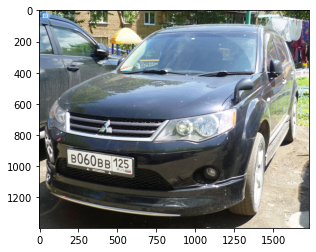

In [ ]:
idx = 0
x = display_data[idx]
print("Image shape:", x[0].shape)
print("BBoxes:", x[1]["boxes"])
print("Labels", x[1]["labels"])
print("Plate texts:", x[1]["texts"])

plt.imshow(x[0])
plt.show()

Сразу для torch.utils.data.DataLoader определим collate_fn, определяющий правило формирования склеивания элементов в батче: (images, targets) - элементы кортежа есть последовательности данных.

In [18]:
def collate_fn(batch):
    images, targets = tuple(zip(*batch))

    return images, targets

In [19]:
train_dataset = DetectPlateDataset(train_config, transforms=transforms)

In [20]:
# Mini-test
data = [train_dataset[i] for i in range(5)]
m_batch = collate_fn(data)
images, targets = m_batch

print("Images:\n", *[image.shape for image in images], end="\n" * 2)
print("Targets:\n", *targets)

Images:
 torch.Size([3, 1396, 1733]) torch.Size([3, 908, 1200]) torch.Size([3, 768, 1024]) torch.Size([3, 967, 1775]) torch.Size([3, 480, 640])

Targets:
 {'boxes': tensor([[ 180.,  889.,  598., 1056.]]), 'labels': tensor([1]), 'texts': ['B060BB125']} {'boxes': tensor([[ 794.,  618., 1009.,  717.],
        [ 942.,  267.,  995.,  283.]]), 'labels': tensor([1, 1]), 'texts': ['M938OX116', 'H881OA116']} {'boxes': tensor([[285., 603., 346., 621.]]), 'labels': tensor([1]), 'texts': ['A549XA163']} {'boxes': tensor([[204., 486., 489., 580.]]), 'labels': tensor([1]), 'texts': ['O934MO190']} {'boxes': tensor([[115., 168., 204., 207.]]), 'labels': tensor([1]), 'texts': ['T647TO35']}


### Отображение данных

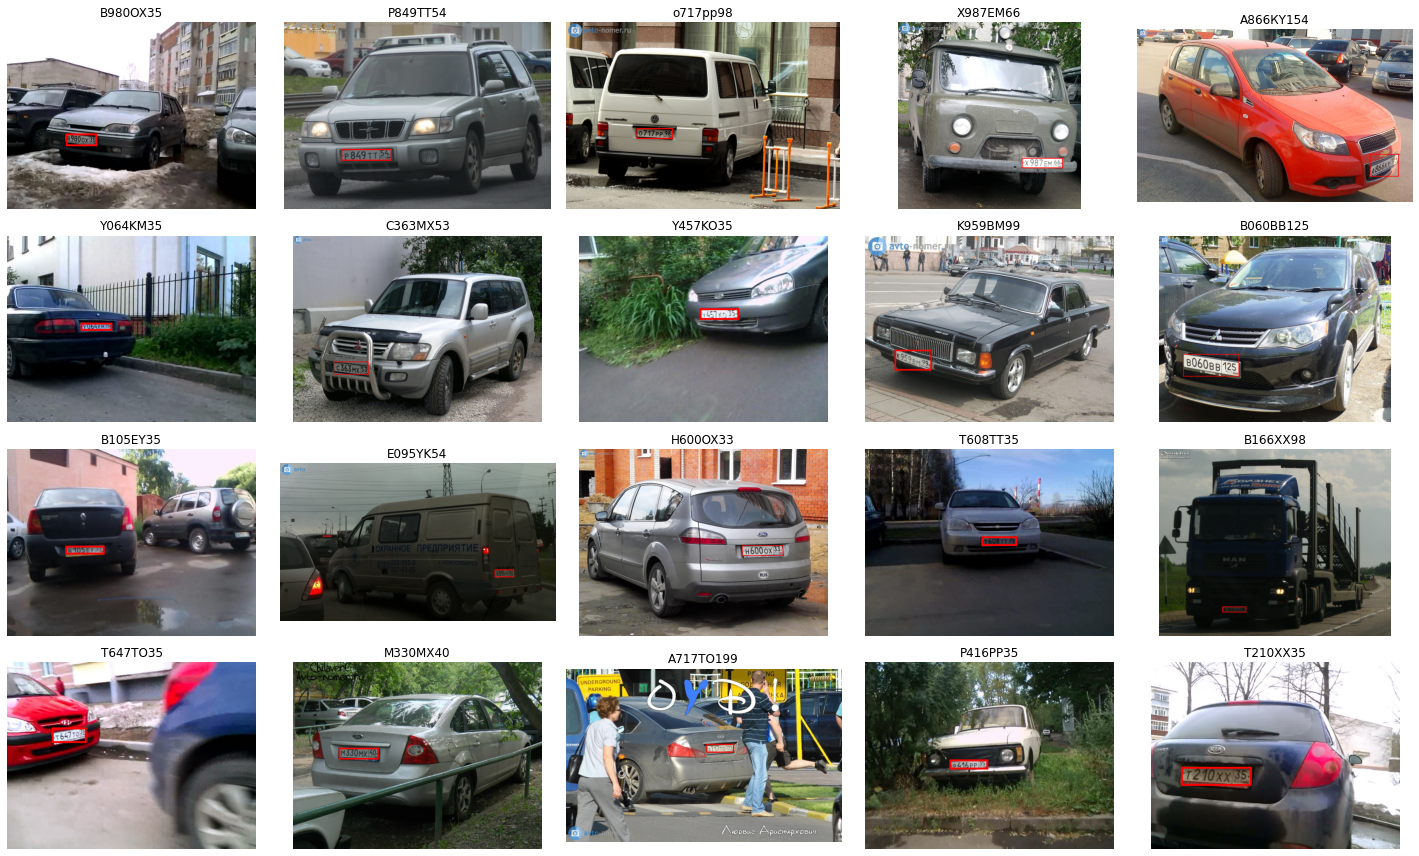

In [ ]:
sample_size = 20
cols = 5
rows = sample_size // cols + int(sample_size % cols != 0)

# Taking some random images
random_idxs = np.random.choice(len(display_data), size=sample_size, replace=False)

plt.figure(figsize=(20, 3 * rows))
for i, idx in enumerate(random_idxs, start=1):
    image = display_data[idx][0]
    text = display_data[idx][1]["texts"]

    # To Tensor and size (C, H, W)
    image = torch.from_numpy(image)
    image = image.permute(2, 0, 1)

    output = torchvision.utils.draw_bounding_boxes(
        image, display_data[idx][1]["boxes"], width=5, colors="#FF0000"
    )

    # Back to (H, W, C)
    image = output.permute(1, 2, 0)
    # index of plt.subplot starts from 1 -> start=1
    plt.subplot(rows, cols, i)

    plt.imshow(image)
    plt.title(" & ".join(text))
    plt.axis("off")

plt.tight_layout()
plt.show()

## Модель

Структура FasterRCNN

In [21]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT
)

for layer in model.children():
    print(layer)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

GeneralizedRCNNTransform(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    Resize(min_size=(800,), max_size=1333, mode='bilinear')
)
BackboneWithFPN(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): FrozenBatchNorm2d(64, eps=0.0)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): FrozenBatchNorm2d(64, eps=0.0)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): FrozenBatchNorm2d(256, eps=0.0)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 2

Возьмем предобученный FasterRCNN и заменим классификатор под нашу задачу (extra класс необходим для background).

In [22]:
def get_model_instance(num_classes=2, weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT):

    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=weights)

    in_features = model.roi_heads.box_predictor.cls_score.in_features

    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [23]:
faster_rcnn = get_model_instance()
faster_rcnn.to(device);

## Обучение модели

In [24]:
# Small batch size due to memory limits
train_generator = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    collate_fn=collate_fn,
)

In [25]:
params = [p for p in faster_rcnn.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=2,
                                               gamma=0.1)

num_epochs = 1

iterations = tqdm(range(num_epochs), desc='epoch')
iterations.set_postfix({'train epoch loss': np.nan})

writer = SummaryWriter(log_dir='./board_loss/experiment_3')

steps = 0
for it in iterations:
    faster_rcnn.train()

    for images, targets in tqdm(train_generator):
        steps += 1
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in target.items() if k != 'texts'}
               for target in targets]
        loss_dict = faster_rcnn(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        writer.add_scalar('Loss/train', losses.cpu().item(), steps)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    iterations.set_postfix({'train epoch loss': losses.cpu().item()})

epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/12811 [00:00<?, ?it/s]

In [3]:
event_acc_1 = EventAccumulator('./board_loss/experiment_1')
event_acc_2 = EventAccumulator('./board_loss/experiment_2')
event_acc_1.Reload()
event_acc_2.Reload()

_, step_nums_1, vals_1 = zip(*event_acc_1.Scalars('Loss/train'))
_, step_nums_2, vals_2 = zip(*event_acc_2.Scalars('Loss/train'))

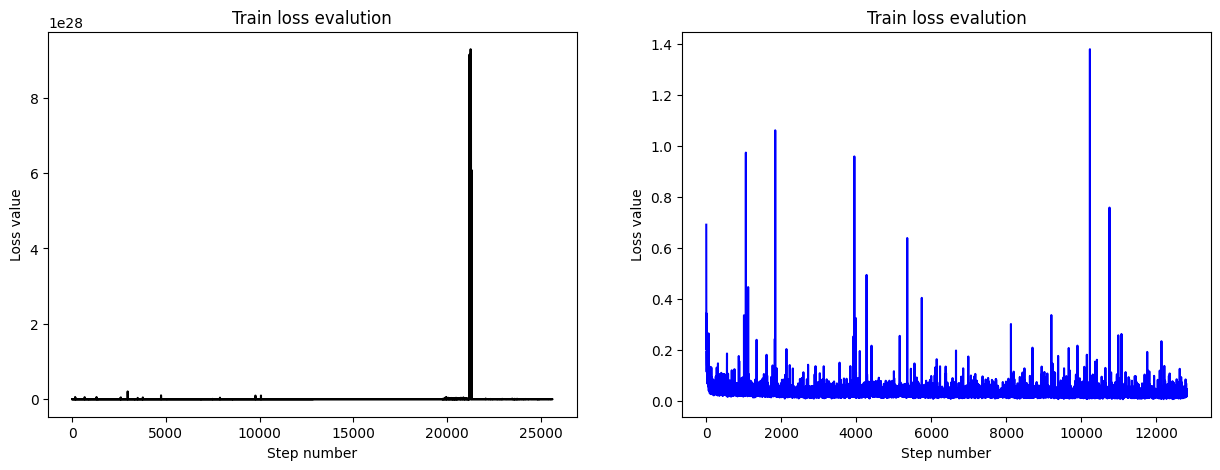

In [4]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))

ax1.plot(step_nums_1, vals_1, color="k")

ax1.set_title("Train loss evalution")
ax1.set_ylabel("Loss value")
ax1.set_xlabel("Step number")

ax2.plot(step_nums_2, vals_2, color="b")

ax2.set_title("Train loss evalution")
ax2.set_ylabel("Loss value")
ax2.set_xlabel("Step number")
plt.show()

Более-менее сходимости удалось достигнуть с Momentum (Рисунок справа), нежели с Adam: "всплески" лосса менее значительны и он целом падает на протяжении всего обучения.

Сохраним веса модели.

In [ ]:
# with open('fasterrcnn_resnet50_1_epochs', 'wb') as fp:
#     torch.save(faster_rcnn.state_dict(), fp)

Загрузка весов.

In [ ]:
model = get_model_instance(weights=None)

with open("fasterrcnn_resnet50_1_epochs", "rb") as f:
    state_dict = torch.load(f, map_location=device)
model.load_state_dict(state_dict, strict=False)
model.to(device);

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

## Оценка качества модели

Предскажем bounding boxes для рандомной подвыборки изображений из теста и оценим на глаз результаты, которая выдает обученная модель.

In [ ]:
test_dataset = DetectPlateDataset(test_config, split="test", transforms=transforms)

Необходимо применить Non-Maximum Suppression, также выбросим предсказания с неуверенным score.

In [ ]:
# Return preds but with valid scores (> threshold)
def preds_but_valid_scores(preds, tshd=0.8):
    for i in range(len(preds)):
        scores = preds[i]["scores"]
        scores = torch.where(scores > tshd, scores, 0.0)
        num = scores.count_nonzero().item()
        # If no score greater than thsd, just take first
        if num == 0:
            num += 1
        preds[i]["boxes"] = preds[i]["boxes"][:num]
        preds[i]["scores"] = preds[i]["scores"][:num]
        del preds[i]["labels"]

In [ ]:
images = []

sample_size = 10
cols = 5
rows = sample_size // cols + int(sample_size % cols != 0)

# Taking some random images
random_idxs = np.random.choice(len(test_dataset), size=sample_size, replace=False)

images = []
for idx in random_idxs:
    image = test_dataset[idx][0]
    images.append(image.to(device))

pred_boxes = []
model.eval()
preds = model(images)

preds = [{k: v.to("cpu") for k, v in prediction.items()} for prediction in preds]

In [ ]:
preds_but_valid_scores(preds)

final_boxes = []
for image in preds:
    inds = torchvision.ops.nms(image["boxes"], image["scores"], 0.3)
    image["boxes"] = image["boxes"][inds]
    final_boxes.append(image["boxes"])

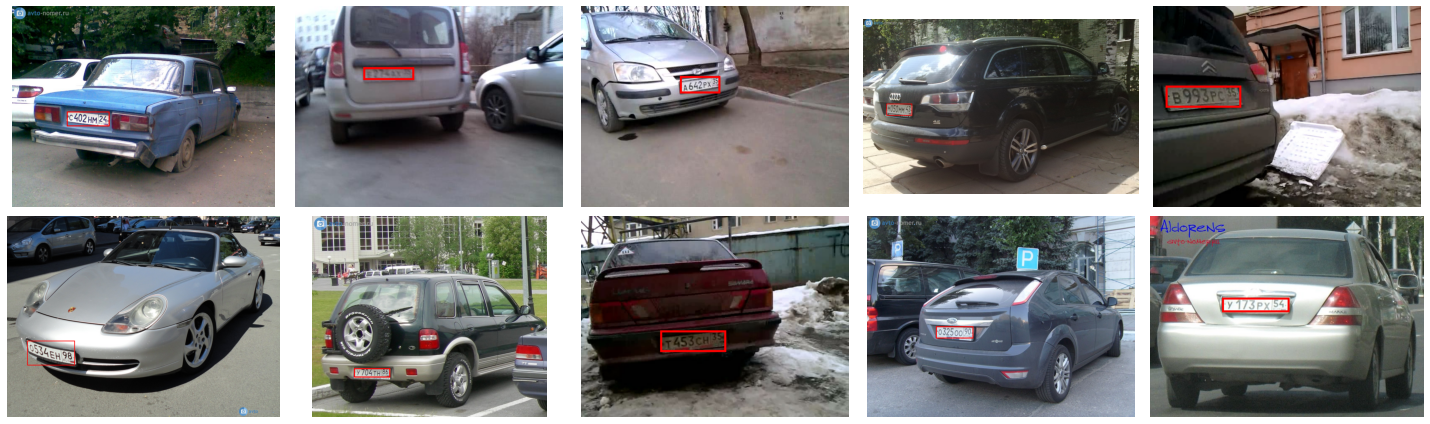

In [ ]:
plt.figure(figsize=(20, 3 * rows))

for i in range(len(images)):
    image = images[i]
    image = (image * 255).type(torch.ByteTensor)

    output = torchvision.utils.draw_bounding_boxes(
        image, final_boxes[i], width=5, colors="#FF0000"
    )

    # Back to (H, W, C)
    image = output.permute(1, 2, 0)
    # index of plt.subplot starts from 1 -> start=1
    plt.subplot(rows, cols, i + 1)

    # flip third dimension as open-cv uses BGR convention
    plt.imshow(image)
    plt.axis("off")

plt.tight_layout()
plt.show()

  Видно, что модель замечательно справляется с детекцией автомобильных номеров.